In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import cv2
import sys
import os
from skimage import io
import matplotlib.pyplot as plt
import random
from shutil import copyfile
from data_aug.data_aug import *
from data_aug.bbox_util import *
import numpy as np
from PIL import Image

In [2]:
df = pd.read_csv('Arandanos_Dataset_Format.csv')
df[['xmin', 'ymin', 'xmax', 'ymax']] = df[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)
df

,filename,xmin,ymin,xmax,ymax,label
0,images/20201124_092900.jpg,40,309,87,362,Arandano Maduro
1,images/20201124_092900.jpg,242,802,272,835,Arandano Maduro
2,images/20201124_092900.jpg,242,839,281,876,Arandano Maduro
3,images/20201124_092900.jpg,358,975,383,1003,Arandano Pinton
4,images/20201124_092900.jpg,388,951,417,986,Arandano Pinton
...,...,...,...,...,...,...
10226,images/20201124_093147.jpg,2200,2779,2246,2832,Arandano Verde
10227,images/20201124_093147.jpg,2207,2747,2258,2796,Arandano Verde
10228,images/20201124_093147.jpg,2224,2711,2268,2755,Arandano Verde
10229,images/20201124_093147.jpg,2179,2685,2219,2720,Arandano Verde


In [3]:
# Helper function, check for correctness by plotting the bounding boxes of the subimage
def plot_bbox(filename, df):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print(f"Image: {img.shape}")
    bboxs = df[df['filename']==filename]
    for index, row in bboxs.iterrows():
        xmin = row['xmin']
        xmax = row['xmax']
        ymin = row['ymin']
        ymax = row['ymax']
        label_name = row['label']
        cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 2)
    plt.figure(figsize=(10,16))
    plt.title('Image with Bounding Box')
    plt.imshow(img)
    plt.axis("off")
    plt.show()

Image: (4032, 3024, 3)


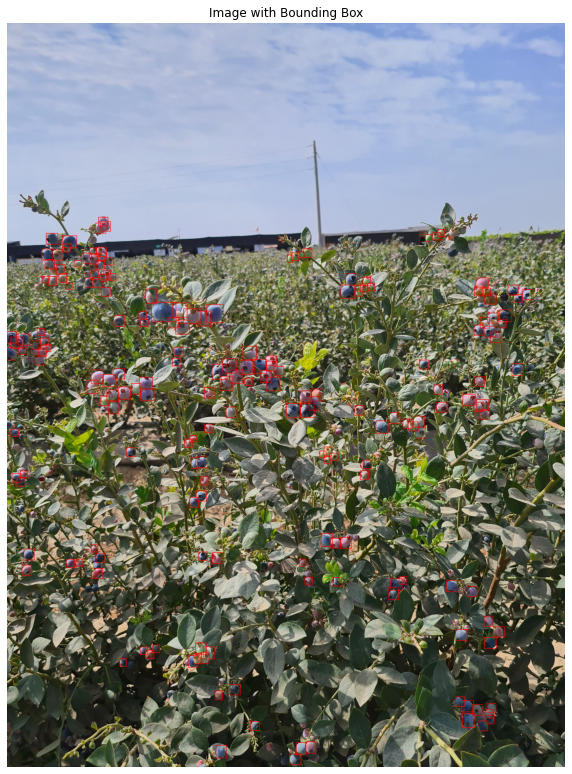

In [4]:
plot_bbox('images/20201124_092919.jpg', df)

#### Separate into train/val 

In [5]:
# Split into train and test
if not os.path.exists('dataset'):
    os.makedirs('dataset')

if not os.path.exists('dataset/train'):
    os.makedirs('dataset/train')

if not os.path.exists('dataset/test'):
    os.makedirs('dataset/test')


RATIO = 0.9 # For 90/10 split

random.seed(1)

# Get images for splitting
all_imgs = os.listdir('images/')
all_imgs = [f for f in all_imgs if not f.startswith('.')]
random.shuffle(all_imgs)
n = len(all_imgs)
limit = int(n*RATIO)

# Split images
train_imgs = all_imgs[:limit]
test_imgs = all_imgs[limit:]

# Save images into train/test directories
for j in range(len(train_imgs)):
    original_path = os.path.join('images/', train_imgs[j])
    new_path = os.path.join('dataset/train/', train_imgs[j])
    copyfile(original_path, new_path)
    
for j in range(len(test_imgs)):
    original_path = os.path.join('images/', test_imgs[j])
    new_path = os.path.join('dataset/test/', test_imgs[j])
    copyfile(original_path, new_path)

In [6]:
# Split annotations into respective images
column_names = ['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'label']
train_df = pd.DataFrame(columns = column_names)
test_df = pd.DataFrame(columns = column_names)

for index, row in df.iterrows():
    filename = row['filename']
    filename = filename.replace('images/', '')
    if filename in train_imgs:
        train_df = train_df.append(row, ignore_index=True)
    if filename in test_imgs:
        test_df = test_df.append(row, ignore_index=True)
        
train_df['filename'] = train_df['filename'].str.replace('images/', 'dataset/train/')
test_df['filename'] = test_df['filename'].str.replace('images/', 'dataset/test/')
train_df

,filename,xmin,ymin,xmax,ymax,label
0,dataset/train/20201124_092900.jpg,40,309,87,362,Arandano Maduro
1,dataset/train/20201124_092900.jpg,242,802,272,835,Arandano Maduro
2,dataset/train/20201124_092900.jpg,242,839,281,876,Arandano Maduro
3,dataset/train/20201124_092900.jpg,358,975,383,1003,Arandano Pinton
4,dataset/train/20201124_092900.jpg,388,951,417,986,Arandano Pinton
...,...,...,...,...,...,...
9230,dataset/train/20201124_093147.jpg,2200,2779,2246,2832,Arandano Verde
9231,dataset/train/20201124_093147.jpg,2207,2747,2258,2796,Arandano Verde
9232,dataset/train/20201124_093147.jpg,2224,2711,2268,2755,Arandano Verde
9233,dataset/train/20201124_093147.jpg,2179,2685,2219,2720,Arandano Verde


#### Augment Data

In [7]:
data = test_df.iloc[:, :].values
data

array([['dataset/train/20201124_092900.jpg', 40, 309, 87, 362,
        'Arandano Maduro'],
       ['dataset/train/20201124_092900.jpg', 242, 802, 272, 835,
        'Arandano Maduro'],
       ['dataset/train/20201124_092900.jpg', 242, 839, 281, 876,
        'Arandano Maduro'],
       ...,
       ['dataset/train/20201124_093147.jpg', 2224, 2711, 2268, 2755,
        'Arandano Verde'],
       ['dataset/train/20201124_093147.jpg', 2179, 2685, 2219, 2720,
        'Arandano Verde'],
       ['dataset/train/20201124_093147.jpg', 2697, 3023, 2735, 3067,
        'Arandano Pinton']], dtype=object)

In [8]:
NUM_IMAGES = 60 # Number of unique images
BBoxes = [[] for y in range(NUM_IMAGES)] # List of bounding boxes

In [9]:
k = 0
img_name = []
img_name.append(data[0][0])
BBoxes[k].append(data[0][1:6])

for i in range(1, len(data)):
    # Check if image is the same
    if data[i][0] == data[i-1][0]:
        BBoxes[k].append(data[i][1:6])
    # If different, add next image and keep adding BBoxes
    else:
        k = k+1
        img_name.append(data[i][0])
        BBoxes[k].append(data[i][1:6])

##### Nothing

In [10]:
k = 0

for i in range(0, len(img_name)):
    img = cv2.imread("{}".format(img_name[i]))[:,:,::-1]
    img_bboxes = BBoxes[i]
    img_bboxes = np.asarray(img_bboxes)
        
    df = pd.DataFrame(data=img_bboxes, columns=['xmin', 'ymin', 'xmax', 'ymax', 'label'])
    k = k+1
    df.insert(loc = 0, column = 'filename', value = 'dataset/train/img{}.jpg'.format(k))
    train_df = train_df.append(df, ignore_index=True)
    
    img = Image.fromarray(img)
    img.save('dataset/train/img{}.jpg'.format(k))

##### Flipping

In [ ]:
k = 61

for i in range(0, len(img_name)):
    img = cv2.imread("{}".format(img_name[i]))[:,:,::-1]
    img_bboxes = BBoxes[i]
    img_bboxes = np.asarray(img_bboxes)
    
    # Transformation
    transforms = Sequence([RandomHorizontalFlip(1)])
    img, img_bboxes = transforms(img, img_bboxes)
        
    df = pd.DataFrame(data=img_bboxes, columns=['xmin', 'ymin', 'xmax', 'ymax', 'label'])
    k = k+1
    df.insert(loc = 0, column = 'filename', value = 'dataset/train/img{}.jpg'.format(k))
    train_df = train_df.append(df, ignore_index=True)
    
    img = Image.fromarray(img)
    img.save('dataset/train/img{}.jpg'.format(k))

##### Scaling

In [ ]:
k = k+1

for i in range(0, len(img_name)):
    img = cv2.imread("{}".format(img_name[i]))[:,:,::-1]
    img_bboxes = BBoxes[i]
    img_bboxes = np.asarray(img_bboxes)
    
    # Transformation
    scale = RandomScale((1.05, 1.1), diff=False)
    img, img_bboxes = scale(img, img_bboxes)

    df = pd.DataFrame(data=img_bboxes, columns=['xmin', 'ymin', 'xmax', 'ymax', 'label'])
    k = k+1
    df.insert(loc = 0, column = 'filename', value = 'dataset/train/img{}.jpg'.format(k))
    train_df = train_df.append(df, ignore_index=True)
    
    img = Image.fromarray(img)
    img.save('dataset/train/img{}.jpg'.format(k))

##### Translation

In [ ]:
k = k+1

for i in range(0, len(img_name)):
    img = cv2.imread("{}".format(img_name[i]))[:,:,::-1]
    img_bboxes = BBoxes[i]
    img_bboxes = np.asarray(img_bboxes)
    
    # Transformation
    translate = RandomTranslate(0.4, diff = True)
    img, img_bboxes = translate(img, img_bboxes)
    
    df = pd.DataFrame(data=img_bboxes, columns=['xmin', 'ymin', 'xmax', 'ymax', 'label'])
    k = k+1
    df.insert(loc = 0, column = 'filename', value = 'dataset/train/img{}.jpg'.format(k))
    train_df = train_df.append(df, ignore_index=True)
    
    img = Image.fromarray(img)
    img.save('dataset/train/img{}.jpg'.format(k))

##### Rotation

In [ ]:
k = k+1

for i in range(0, len(img_name)):
    img = cv2.imread("{}".format(img_name[i]))[:,:,::-1]
    img_bboxes = BBoxes[i]
    img_bboxes = np.asarray(img_bboxes)
    
    # Transformation
    rotate = RandomRotate(10)  ## rotating by 10 degrees
    img, img_bboxes = rotate(img, img_bboxes)
    
    df = pd.DataFrame(data=img_bboxes, columns=['xmin', 'ymin', 'xmax', 'ymax', 'label'])
    k = k+1
    df.insert(loc = 0, column = 'filename', value = 'dataset/train/img{}.jpg'.format(k))
    train_df = train_df.append(df, ignore_index=True)
    
    img = Image.fromarray(img)
    img.save('dataset/train/img{}.jpg'.format(k))

##### Shearing

In [ ]:
k = k+1

for i in range(0, len(img_name)):
    img = cv2.imread("{}".format(img_name[i]))[:,:,::-1]
    img_bboxes = BBoxes[i]
    img_bboxes = np.asarray(img_bboxes)
    
    # Transformation
    shear = RandomShear(0.4)  
    img, img_bboxes = shear(img, img_bboxes)
    
    df = pd.DataFrame(data=img_bboxes, columns=['xmin', 'ymin', 'xmax', 'ymax', 'label'])
    k = k+1
    df.insert(loc = 0, column = 'filename', value = 'dataset/train/img{}.jpg'.format(k))
    train_df = train_df.append(df, ignore_index=True)
    
    img = Image.fromarray(img)
    img.save('dataset/train/img{}.jpg'.format(k))

##### Flip Scale

In [ ]:
k = k+1

for i in range(0, len(img_name)):
    img = cv2.imread("{}".format(img_name[i]))[:,:,::-1]
    img_bboxes = BBoxes[i]
    img_bboxes = np.asarray(img_bboxes)
    
    # Transformation
    transform = Sequence([RandomHorizontalFlip(1), RandomScale((1.05, 1.1), diff=False)])
    img, img_bboxes = transform(img, img_bboxes)
        
    df = pd.DataFrame(data=img_bboxes, columns=['xmin', 'ymin', 'xmax', 'ymax', 'label'])
    k = k+1
    df.insert(loc = 0, column = 'filename', value = 'dataset/train/img{}.jpg'.format(k))
    train_df = train_df.append(df, ignore_index=True)
    
    img = Image.fromarray(img)
    img.save('dataset/train/img{}.jpg'.format(k))

##### Flip Brightness

In [ ]:
k = k+1

for i in range(0, len(img_name)):
    img = cv2.imread("{}".format(img_name[i]))[:,:,::-1]
    img_bboxes = BBoxes[i]
    img_bboxes = np.asarray(img_bboxes)
    
    # Transformation
    transform = Sequence([RandomHorizontalFlip(1), RandomHSV(low=0.5, high=1.5)])
    img, img_bboxes = transform(img, img_bboxes)
        
    df = pd.DataFrame(data=img_bboxes, columns=['xmin', 'ymin', 'xmax', 'ymax', 'label'])
    k = k+1
    df.insert(loc = 0, column = 'filename', value = 'dataset/train/img{}.jpg'.format(k))
    train_df = train_df.append(df, ignore_index=True)
    
    img = Image.fromarray(img)
    img.save('dataset/train/img{}.jpg'.format(k))

#### Flip Rotate

In [ ]:
train_df[['xmin', 'ymin', 'xmax', 'ymax']] = train_df[['xmin', 'ymin', 'xmax', 'ymax']].astype('int32')
train_df

In [ ]:
train_df.to_csv('dataset/train_df.csv', index=False)
test_df.to_csv('dataset/test_df.csv', index=False)

##### Check for correctness

In [ ]:
for file in train_df['filename'].sample(n=5):
    plot_bbox(file, train_df)

#### Create .txt file for annotations

In [ ]:
# Create .txt for training model

with open("dataset/train_annotations.txt", "w+") as f:
    for idx, row in train_df.iterrows():
        sys.stdout.write(str(idx) + '\r')
        sys.stdout.flush()
        x1 = int(row['xmin'])
        x2 = int(row['xmax'])
        y1 = int(row['ymin'])
        y2 = int(row['ymax'])

        fileName = row['filename']
        className = row['label']
        f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

In [ ]:
with open("dataset/test_annotations.txt", "w+") as f:
    for idx, row in test_df.iterrows():
        sys.stdout.write(str(idx) + '\r')
        sys.stdout.flush()
        x1 = int(row['xmin'])
        x2 = int(row['xmax'])
        y1 = int(row['ymin'])
        y2 = int(row['ymax'])

        fileName = row['filename']
        className = row['label']
        f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')